In [57]:
!pip install fashion-clip faiss-cpu

In [58]:
!pip install torch
!pip install faiss-cpu
!pip install numpy
!pip install torchvision
!pip install tqdm
!pip install pillow


In [59]:
!pip install fashion-clip


In [60]:
!pip install --upgrade pip setuptools wheel


  Using cached pip-25.0.1-py3-none-any.whl.metadata (3.7 kB)
  Using cached setuptools-75.8.0-py3-none-any.whl.metadata (6.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.0.1-py3-none-any.whl (1.8 MB)
Using cached setuptools-75.8.0-py3-none-any.whl (1.2 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)


ERROR: To modify pip, please run the following command:
C:\Users\SMHRD\anaconda3\python.exe -m pip install --upgrade pip setuptools wheel


In [61]:
!pip install timm

In [62]:
import os
import torch
import faiss
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
from fashion_clip.fashion_clip import FashionCLIP

In [68]:
# 작업 디렉토리 및 이미지 경로 설정
WorkDir = 'C:\\Users\\SMHRD\\Desktop\\5g\\5G\\back\\projectmodel\\project_model\\image_embedding'
ImagePath = 'C:\\Users\\SMHRD\\Desktop\\5g\\5G\\back\\projectmodel\\project_model\\image_segmentation\\output'


In [64]:
# FashionCLIP 모델 로드
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionCLIP("fashion-clip")  # ✅ device 인자 제거

def transform_image(img):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(img).unsqueeze(0).to(device)  # ✅ 입력 이미지를 device로 이동


In [65]:
if not os.path.exists(ImagePath):
    print(f"❌ 오류: {ImagePath} 경로가 존재하지 않습니다.")
else:
    print(f"✅ 확인됨: {ImagePath}")

✅ 확인됨: C:\Users\SMHRD\Desktop\5g\5G\back\projectmodel\project_model\image_segmentation\output


In [66]:
# 이미지 로드 및 변환
images = dict()
for img_path in tqdm(os.listdir(ImagePath)):
    path = os.path.join(ImagePath, img_path)
    if os.path.isfile(path) and img_path.endswith('.jpg'):
        try:
            images[path] = path  # ✅ 이미지 경로 저장
        except Exception as e:
            print(f"Error loading {path}: {e}")

100%|██████████| 5500/5500 [00:00<00:00, 14329.83it/s]


In [69]:
# 배치 크기 설정 및 임베딩 추출
batch_size = 16  
image_keys = list(images.keys())  
num_batches = len(image_keys) // batch_size + (1 if len(image_keys) % batch_size != 0 else 0)
all_embeddings = []

for i in tqdm(range(num_batches), desc="Encoding images"):
    batch_keys = image_keys[i * batch_size: (i + 1) * batch_size]  
    batch_images = [images[key] for key in batch_keys]  # ✅ 경로 리스트 유지
    with torch.no_grad():
        batch_embeddings = model.encode_images(batch_images, batch_size=len(batch_images))  # ✅ 이미지 경로 전달
    all_embeddings.append(batch_embeddings)  # ✅ 이미 numpy 배열이므로 .cpu() 제거


Encoding images: 100%|██████████| 344/344 [22:56<00:00,  4.00s/it]


In [70]:
embeddings = np.vstack(all_embeddings)

In [71]:
keys = list(images.keys())

In [72]:
embeddings.shape

(5500, 512)

In [ ]:

np.save(os.path.join(WorkDir, 'image_embeddings.npy'), embeddings)

In [73]:
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss.normalize_L2(embeddings)
faiss_index.add(embeddings)

##### 비슷한 이미지 찾아보기

In [74]:
index = 5

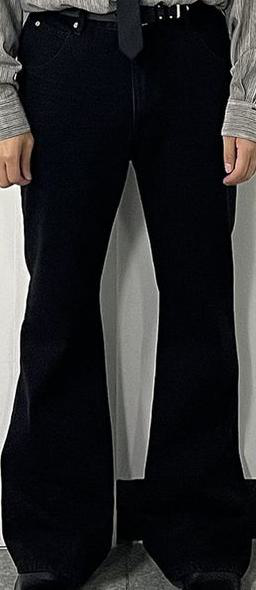

In [81]:
Image.open(keys[index])

In [78]:
print(f"FAISS 인덱스 크기: {faiss_index.ntotal}, 임베딩 크기: {embeddings.shape}")


FAISS 인덱스 크기: 5500, 임베딩 크기: (5500, 512)


In [79]:
index = 0  # 검색할 샘플 인덱스 (임의의 값 설정)
if index < embeddings.shape[0]:
    query_vector = embeddings[index].reshape(1, -1)

    # FAISS 검색 수행 (k 값 줄이기)
    D, I = faiss_index.search(query_vector, 3)

    print("🔹 검색 결과:", I)
    print("🔹 거리:", D)
else:
    print("❌ 오류: 검색할 인덱스가 임베딩 범위를 초과했습니다.")

🔹 검색 결과: [[   0 2645 4998]]
🔹 거리: [[0.         0.2300335  0.23507833]]


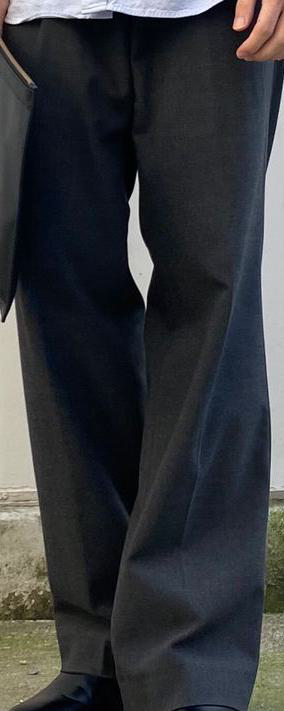

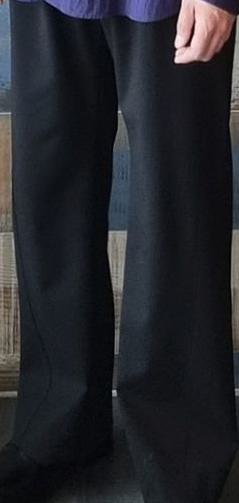

In [80]:
for i in I[0][1:]:
    display(Image.open(keys[i]))